# Flujo Monofásico en 2D con SciPy

**Objetivo general**
- El alumno resolverá la ecuación de Laplace en dos dimensiones, la cual representa el flujo monofásico incompresible en estado estable, con propiedades del fluido y del medio constantes. Mediante la solución de esta ecuación, se conocerán los tipos de condiciones de frontera y los tipos de solvers que se aplican en la solución de problemas relacionados con la Simulación Matemática de Yacimientos (SMY).

**Objetivos particulares**
- Conocer los diferentes tipos de "solvers" para los sistemas de ecuaciones lineales.
- Identificar la dirección del flujo de fluidos de acuerdo a las isobaras.

## Contenido
- [1 - Implementación de SciPy](#1)
    - [1.1 - ](#3.1)
    - [Ejercicio 1](#ej-1)

# 1 Implementación de SciPy

La  biblioteca de scipy permite utilizar una basta cantidad de algoritmos, solvers y funciones cientificas. El uso de éstas logra resolver el problema cientifico en mucho menos tiempo. Como alternativa al algoritmo de Thomas, se plantea el uso de los siguientes solvers:
- gmres
- bicgstab
- spsolve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import funciones_personalizadas as fp

from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import bicgstab

### Funciones auxiliares del jupyter anterior
- ecuaciones_discretizadas
- condiciones_de_frontera_dirichlet

In [2]:
def ecuaciones_discretizadas(lx, ly, nx, ny, hx, hy):
    """
    Esta funcion genera los coeficientes de la ecuacion de flujo monofasico discretizada. No se consideran las
    condiciones de frontera.
    Parametros
    ----------
    lx, ly : entero o flotante.
        Longitud en el eje x e y.
    nx, ny : int, int.
        Nodos en de la malla rectangular.
    Retorna
    -------
    AP,AE,AW,AN,AS,B : ndarray. 
        Arreglos en 2D para generar una matriz pentadiagonal.
    """
    
    # se definen los arreglos en dos dimensiones
    AP = np.zeros((nx,ny)) 
    AE = np.zeros((nx,ny))
    AW = np.zeros((nx,ny))
    AN = np.zeros((nx,ny))
    AS = np.zeros((nx,ny))
    B = np.zeros((nx,ny))
    
    for j in range (1,ny-1):
        for i in range (1,nx-1):
            AP[i][j]=2.0/hx**2.0+2.0/hy**2.0
            AE[i][j]=1.0/hx**2.0
            AW[i][j]=1.0/hx**2.0
            AN[i][j]=1.0/hy**2.0
            AS[i][j]=1.0/hy**2.0
            B[i][j]=0.0

    return AP,AE,AW,AN,AS,B

In [3]:
def condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny):
    """
    Esta función modifica los coeficientes y asigna las condiciones de frotera de primera clase. 
    """
    for i in range (1,nx-1):
        AP[i][0]=1.0
        AW[i][0]=0.0    
        AE[i][0]=0.0      #Frontera sur
        AN[i][0]=0.0
        B[i][0]=P2
            
        AP[i][ny-1]=1.0
        AW[i][ny-1]=0.0    
        AE[i][ny-1]=0.0    #Frontera norte
        AS[i][ny-1]=0.0
        B[i][ny-1]=P4

    for j in range (0,ny):
        AP[0][j]=1.0
        AE[0][j]=0.0      #Frontera Oeste
        AN[0][j]=0.0
        AS[0][j]=0.0
        B[0][j]=P1
        
        AP[nx-1][j]=1.0
        AW[nx-1][j]=0.0
        AN[nx-1][j]=0.0   #Frontera Este
        AS[nx-1][j]=0.0
        B[nx-1][j]=P3

### Uso de SciPy

In [4]:
def flujo_monofasico_2d_scipy(nx, ny, lx, ly):
    """
    Esta función resuelve el problema de flujo monofásico en 2D con ayuda de la libreria SciPy y sus solvers.  
    """
    
    """
        |---P4(NORTE)---|
        |               |
    P1(OESTE)        P3(ESTE)
        |               |
        |----P2(SUR)----|
    """

    P1, P2, P3, P4  = 1000.0, 500.0, 500.0, 500.0
    Press= np.zeros((nx,ny))

    #Generación de malla para graficar
    x = np.linspace(0, lx, nx)
    y = np.linspace(0, ly, ny)
    malla_x, malla_y = np.meshgrid(x, y)
    
    # se calcula el espaciamiento entre nodos
    hx = lx/(nx-1)
    hy = ly/(ny-1)
    
    # Llamar a la función para obtener los coeficientes
    AP, AW, AE, AN, AS, B = ecuaciones_discretizadas(lx, ly, nx, ny, hx, hy)

    
    #Aplicar fronteras de primera clase (Dirichlet)
    condiciones_de_frontera_dirichlet(P1, P2, P3, P4, AP, AW, AE, AN, AS, B, nx, ny)
    
    
    n = nx*ny
    A = np.zeros((n,n))
    Press1 = np.zeros(n)
    B1 = np.zeros(n)

    for j in range (0,ny):
        for i in range (0,nx):
            k=i+nx*j     
            A[k][k] = AP[i][j]
            B1[k] = B[i][j]
        
            if j < ny-1: A[k][k+nx] = -AN[i][j]
            if i < nx-1: A[k][k+1] = -AE[i][j]
            if i > 0: A[k][k-1] = -AW[i][j]
            if j > 0: A[k][k-nx] = -AS[i][j]    
                
    A1 = lil_matrix(A)
    A1 = A1.tocsr()
    
    
    Press1 = gmres(A1, B1, tol=1.0E-07, restart = 2000)  #scipy.sparse.linalg.gmres(A, b, x0=None, tol=1e-05, restart=None, maxiter=None, xtype=None, M=None, callback=None, restrt=None)[source]¶
    #Press1 = bicgstab(A1, B1, tol=1.0E-05)  #scipy.sparse.linalg.gmres(A, b, x0=None, tol=1e-05, restart=None, maxiter=None, xtype=None, M=None, callback=None, restrt=None)[source]¶
    #Press1 = spsolve(A1, B1)  #scipy.sparse.linalg.gmres(A, b, x0=None, tol=1e-05, restart=None, maxiter=None, xtype=None, M=None, callback=None, restrt=None)[source]¶

    for j in range (0,ny):
        for i in range (0,nx):
            k=i+j*nx
            Press[i][j]=Press1[0][k]    #Cuando se utilizan los algoritmos del subespacio de Krilov el resultado es una matriz de tamaño 1 X nx*ny
            #Press[i][j]=Press1[k]    #Cuando se utiliza spsolve (descomposición LU) el resultado es un vector de tamaño 1 X nx*ny

    # graficar
    fp.graficar_isobaras_presion_y_campo_velocidad(nx, ny, hx, hy, malla_x, malla_y, Press)

In [5]:
nx, ny = 40, 40
lx, ly = 500, 500

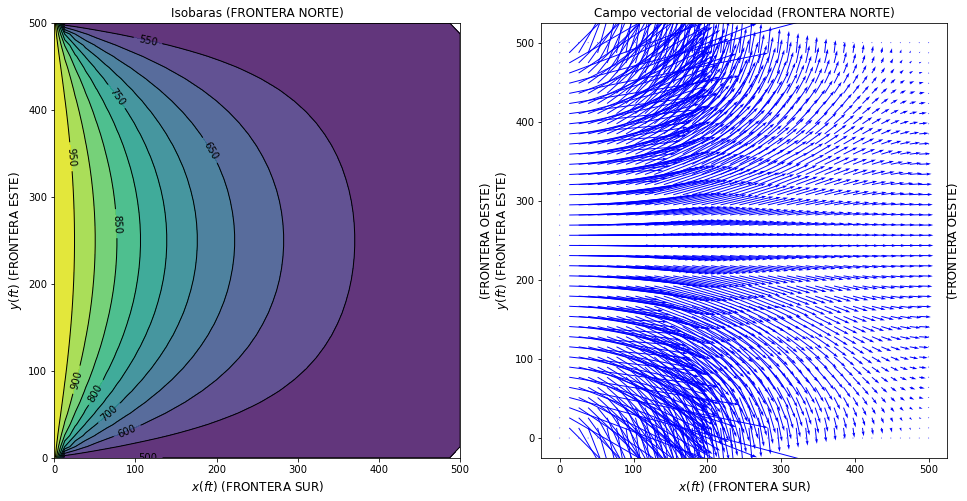

Wall time: 2.24 s


In [6]:
%%time
flujo_monofasico_2d_scipy(nx, ny, lx, ly)

## Ejercicio 3 - Uso de SciPy

En el script **widgets.interact(flujo_monofasico_2d_scipy_animacion, presion_cambiante = widgets.Play(min=600, max=1000))**:

    1.- Cambia el rango de presiones desde 750 psi a 1,400 psi.

En el script **flujo_monofasico_2d_scipy_animacion(presion_cambiante)**:

    2.- Asigna la variable --> presion_cambiante a P3 y el resto de presiones con el valor de 600 psi.
    
    3.- Comenta las lineas de codigo pertenecientes al solver gmres --> Press1 = gmres(A1, B1, tol=1.0E-07, restart = 2000) y --> Press[i][j]=Press1[0][k]
    
    4.- Descomenta las lineas de codigo pertenecientes a spsolve --> Press1 = spsolve(A1, B1) y --> Press[i][j]=Press1[k]

    5.- Ejecuta las celdas de codigo modificadas y visualiza los resultados